# Navigation

---

Congratulations for completing the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893)!  In this notebook, you will learn how to control an agent in a more challenging environment, where it can learn directly from raw pixels!  **Note that this exercise is optional!**

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/VisualBanana.app"`
- **Windows** (x86): `"path/to/VisualBanana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/VisualBanana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/VisualBanana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/VisualBanana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/VisualBanana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/VisualBanana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `VisualBanana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="VisualBanana.app")
```

In [2]:
#env = UnityEnvironment(file_name="VisualBanana_Linux/Banana.x86_64")
env = UnityEnvironment(file_name="VisualBanana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 1
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 0
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The environment state is an array of raw pixels with shape `(1, 84, 84, 3)`.  *Note that this code differs from the notebook for the project, where we are grabbing **`visual_observations`** (the raw pixels) instead of **`vector_observations`**.* A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

Number of agents: 1
Number of actions: 4
States look like:


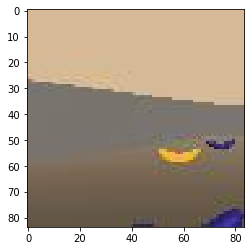

States have shape: (1, 84, 84, 3)


In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.visual_observations[0]
print('States look like:')
plt.imshow(np.squeeze(state))
plt.show()
state_size = state.shape
print('States have shape:', state.shape)

### 3. Implement an Agent

I extended `dqn_agent.py` by a parameter called `use_cnn`. If this parameter is set to `True` then the agent uses the neural network architecture with convolutional layers in `cnn_model.py` to map visual states to action values.

### 4. Train the Agent

In [5]:
from IPython.display import clear_output
from matplotlib import pyplot as plt

%matplotlib notebook

def init_plot():
    fig,ax = plt.subplots(1,1)
    ax.grid(True)
    ax.set_xlabel('Episode #')
    return fig, ax

def live_plot(fig, ax, data_dict, figsize=(7,5), title=''):
    if ax.lines:
        for line in ax.lines:
            line.set_xdata(list(range(len(data_dict[line.get_label()]))))
            line.set_ydata(data_dict[line.get_label()])
        ax.set_xlim(0, len(data_dict[line.get_label()]))
        
    else:
        for label,data in data_dict.items():
            line, = ax.plot(data)
            line.set_label(label)
            ax.legend()
        ax.set_ylim(0, 20)
    
    fig.canvas.draw()

<IPython.core.display.Javascript object>


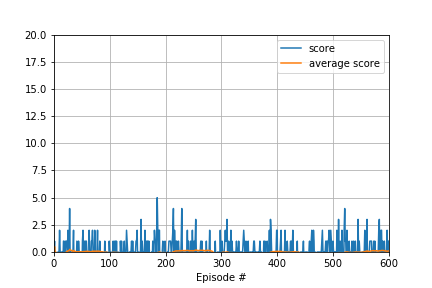

Episode 100	Average Score: -0.05 	Duration: 4.177067 Min
Episode 200	Average Score: -0.05 	Duration: 4.165479 Min
Episode 300	Average Score: -0.07 	Duration: 4.368262 Min
Episode 400	Average Score: 0.05 	Duration: 4.205064 Min
Episode 500	Average Score: -0.09 	Duration: 4.582547 Min
Episode 600	Average Score: 0.09 	Duration: 4.357227 Min


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


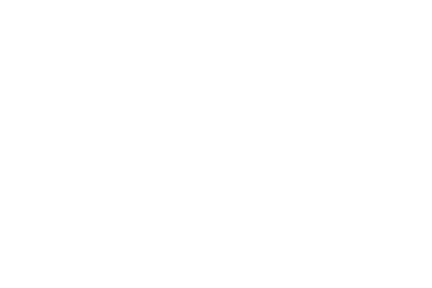

In [6]:
import time
import torch
from collections import defaultdict, deque

from dqn_agent import Agent

def train(agent, n_episodes=600, eps_start=1.0, eps_end=0.01, eps_decay=0.995, episodes_per_print=100):
    """
    Params
    ======
        n_episodes (int): maximum number of training episodes
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = defaultdict(list)         # list containing scores from each episode and average scores
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    
    fig,ax = init_plot()
    
    for i_episode in range(1, n_episodes+1):
        episode_start = time.time()
        
        # reset environment and score
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.visual_observations[0]
        score = 0
        
        # run for 1 episode
        while True:
            action = agent.act(state, eps)
            env_info = env.step(action.astype(int))[brain_name]
            next_state = env_info.visual_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            
            # update score and state
            score += reward
            state = next_state
            if done:
                break
                
        # save score
        scores_window.append(score)
        scores["score"].append(score)
        scores["average score"].append(np.mean(scores_window))
        
        # decrease epsilon
        eps = max(eps_end, eps_decay*eps)
        
        # print current performance
        live_plot(fig, ax, scores)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % episodes_per_print == 0:
            print('\rEpisode {}\tAverage Score: {:.2f} \tDuration: {:.6f} Min'.format(i_episode, 
                                                                                      np.mean(scores_window), 
                                                                                     (time.time() - episode_start) / 60. * episodes_per_print
                                                                                     ))
            torch.save(agent.qnetwork_local.state_dict(), 'pixels_checkpoint.pth')
            
    return scores

agent = Agent(np.prod(state_size), action_size, seed=0, buffer_size=100, batch_size=32, lr=0.00025, 
              gradient_momentum=0.95, use_cnn=True)
scores = train(agent, eps_start=1.0, eps_end=0.1, eps_decay=0.995)

In [ ]:
import torch

from dqn_agent import Agent

agent = Agent(state_size, action_size, seed=0)

# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('pixels_checkpoint.pth'))

# reset environment and score
env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations[0]
score = 0

# run for one episode
while True:
    action = agent.act(state, eps=0.)
    env_info = env.step(action)[brain_name]
    next_state = env_info.vector_observations[0]
    reward = env_info.rewards[0]
    done = env_info.local_done[0]
    score += reward
    state = next_state
    if done:
        break
    
print("Score: {}".format(score))

In [ ]:
env.close()